# M17 Eye Diagram

Generate eye diagrams for M17 baseband signals.

This notebook accepts M17 baseband signals.  The baseband must be signed 16-bit,
single channel, 48ksps WAV format.

If you need to convert a raw file to WAV, you can use the following command.

    sox -t s16 -r 48k -c1 input.raw output.wav

Also, `gqrx` will capture baseband audio in wav format.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

INPUT = 'M17_test.wav'
#INPUT = 'm17-4fsk.wav'

Change the input filename in the above section.

The first thing we do is load the baseband signal from the file.

In [2]:
import scipy
import scipy.signal
import scipy.io.wavfile

sample_rate, baseband_data = scipy.io.wavfile.read(INPUT)
baseband_data = baseband_data / 1000.0
symbol_rate = 4800
samples_per_symbol = int(sample_rate / symbol_rate)

Our next step is to apply the appropriate RRC filter to the data.

In [3]:
from scipy.signal import lfiltic, lfilter
from commpy.filters import rrcosfilter

taps = rrcosfilter(int(samples_per_symbol * 15), 0.5, 1.0, 10.0)[1][1:]
delay = len(taps) // 2
zl = lfiltic(taps, 1.0, [], [])
filtered_data, zl = lfilter(taps, 1.0, np.concatenate([baseband_data, np.zeros(delay)]), -1, zl)
filtered_data *= 0.125

Now we need to define the function for displaying the eye diagram.

This is taken from here: https://notebook.community/daniestevez/jupyter_notebooks/dslwp/paper/Eye%20diagram


In [4]:
def plot_eye(eye, limit, title):
    heatmap = np.vstack([np.histogram(eye[:,j], bins = np.linspace(-2,2,100))[0]/eye.shape[0] for j in np.arange(eye.shape[1])]).T
    
    heatmap_cum = np.zeros_like(heatmap)
    ps = np.concatenate((np.logspace(-3,-1,3), [0.25,0.5,0.75]))
    for p in ps:
        levels = -np.sort(-heatmap, axis = 0)
        a = np.argmax(np.cumsum(levels, axis = 0) >= 1-p, axis = 0)
        cut = levels[a, np.arange(levels.shape[1])]
        heatmap_cum[heatmap >= cut] = p
    
    plt.figure(figsize = (10,6), facecolor = 'w')
    time = (np.arange(eye.shape[1])-eye.shape[1]//2)/48000.0
    plt.plot(time*1e3, eye[:1000,:].T, color = 'C0', alpha = 0.1)
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (ms)')

def process(data, samples_per_symbol):
    limit = np.max(data)
    extra = len(data) % samples_per_symbol
    if extra != 0:
        data = np.concatenate([data, np.zeros(samples_per_symbol - extra)])
    plot_eye(data.reshape((-1, samples_per_symbol)), limit + 1, "M17 4-FSK Eye Diagram")

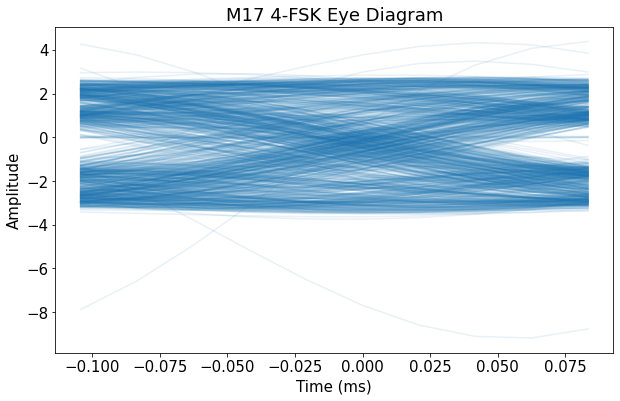

In [5]:
process(filtered_data, samples_per_symbol)